# Auditing an MLM trained on WikiText using an LRT Attack

## Introduction

In this tutorial, we will see:

- How to specify the dataset and model for Privacy Meter
- How to audit a HuggingFace masked language model
- How to create and use a new metric called `LrtMetric` to evaluate membership leakage using custom likelihood ratio values using the target model and a reference model
- How to visualize the audit result

## Imports

In [1]:
import sys
import numpy as np
import torch

In [ ]:
!{sys.executable} -m pip install datasets
!{sys.executable} -m pip install transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer

In [3]:
!{sys.executable} -m pip install -e ../.
from privacy_meter.audit import Audit
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import *
from privacy_meter.dataset import Dataset
from privacy_meter.hypothesis_test import threshold_func
from privacy_meter.information_source import InformationSource
from privacy_meter.information_source_signal import Signal, ModelMaskedLoss
from privacy_meter.metric import Metric
from privacy_meter.metric_result import MetricResult
from privacy_meter.model import HuggingFaceMaskedLanguageModel
from privacy_meter.utils import flatten_array

Obtaining file:///Users/aadyaamaddi/Desktop/ML%20Privacy%20Meter/privacy_meter
  Attempting uninstall: privacy-meter
    Found existing installation: privacy-meter 1.0
    Uninstalling privacy-meter-1.0:
      Successfully uninstalled privacy-meter-1.0
  Running setup.py develop for privacy-meter


## Settings

Setting seed for reproducibility:

In [4]:
seed = 1234
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)

Hyperparameters:

In [5]:
# for the target and reference models
num_train_data = 25
num_test_data = 25
loss_fn = torch.nn.CrossEntropyLoss()
prob_mask = 0.15
num_times_mask = 20
stride = 64

In [6]:
# for the LRT metric
num_reference_models = 1
fpr_tolerance_list = [
    0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
]

## Load dataset and models using HuggingFace 

We load the WikiText dataset using the `datasets` module in HuggingFace:

In [7]:
from datasets import load_dataset
hf_dataset = load_dataset('wikitext', 'wikitext-103-v1')

Reusing dataset wikitext (/Users/aadyaamaddi/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/aa5e094000ec7afeb74c3be92c88313cd6f132d564c7effd961c10fd47c76f20)


  0%|          | 0/3 [00:00<?, ?it/s]

Next, we load the pre-trained target and reference models using the helper classes `AutoTokenizer` and `AutoModelForMaskedLM` in the `transformers` module in HuggingFace:

In [8]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

target_tokenizer = AutoTokenizer.from_pretrained("saghar/TinyBERT_General_6L_768D-finetuned-wikitext103")
target_model = AutoModelForMaskedLM.from_pretrained("saghar/TinyBERT_General_6L_768D-finetuned-wikitext103")

reference_tokenizer = AutoTokenizer.from_pretrained("saghar/MiniLMv2-L6-H384-distilled-from-RoBERTa-Large-finetuned-wikitext103")
reference_model = AutoModelForMaskedLM.from_pretrained("saghar/MiniLMv2-L6-H384-distilled-from-RoBERTa-Large-finetuned-wikitext103")

We process the raw dataset to be compatible with the models. This includes filtering out empty sequences, tokenizing the dataset for both the target and reference models, and batching the dataset:

In [ ]:
# remove empty rows from dataset
hf_dataset = hf_dataset.filter(lambda elem: len(elem["text"]) > 0)

In [ ]:
# tokenize function for target model
def target_tokenize_fn(examples):
    return target_tokenizer(examples["text"])

# tokenize function for reference model
def reference_tokenize_fn(examples):
    return reference_tokenizer(examples["text"])

tokenized_target_hf_dataset = hf_dataset.map(
    target_tokenize_fn, batched=True, num_proc=2, remove_columns=["text"]
)

tokenized_reference_hf_dataset = hf_dataset.map(
    reference_tokenize_fn, batched=True, num_proc=2, remove_columns=["text"]
)

In [ ]:
# batch dataset
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    
    total_length = (total_length // block_size) * block_size
    
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    
    result["labels"] = result["input_ids"].copy()
    return result

lm_target_hf_dataset = tokenized_target_hf_dataset.map(
    group_texts, batched=True, batch_size=64, num_proc=2
)

lm_reference_hf_dataset = tokenized_reference_hf_dataset.map(
    group_texts, batched=True, batch_size=64, num_proc=2
)

We split the dataset into train and test for both the target and reference models:

In [12]:
# split into train and test for target model
target_train_split = lm_target_hf_dataset["train"].select(range(num_train_data))
target_test_split =  lm_target_hf_dataset["test"].select(range(num_test_data))

# split into train and test for reference model
# note: we create new objects for the reference model because it can use a different tokenizer,
#       but the original text for the sequences will be the same as they are for the target model
reference_train_split = lm_reference_hf_dataset["train"].select(range(num_train_data))
reference_test_split =  lm_reference_hf_dataset["test"].select(range(num_test_data))

We set the format of the dataset splits as `numpy` arrays, so we can use them with Privacy Meter `Dataset` objects:

In [13]:
# set format of datasets to be compatible with Privacy Meter
target_train_split.set_format("numpy")
target_test_split.set_format("numpy")
reference_train_split.set_format("numpy")
reference_test_split.set_format("numpy")

Finally, we create `Dataset` objects for both the target and reference models:

In [14]:
# create Dataset for target model
train_ds = {'input': target_train_split['input_ids']}
test_ds = {'input': target_test_split['input_ids']}
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='input',
    default_output=None
)

In [15]:
# create Dataset for reference model
train_ds = {'input': reference_train_split['input_ids']}
test_ds = {'input': reference_test_split['input_ids']}
reference_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='input',
    default_output=None
)

Additionally, we use the `HuggingFaceMaskedLanguageModel` class defined in Privacy Meter's `model.py` to create wrapper objects for querying these models conveniently:

In [16]:
# create Privacy Meter compatible wrapper objects for the models
wrapped_target_model = HuggingFaceMaskedLanguageModel(model_obj=target_model, loss_fn=loss_fn,
                                                      tokenizer=target_tokenizer,
                                                      prob_mask=prob_mask,
                                                      num_times_mask=num_times_mask,
                                                      stride=stride)
wrapped_reference_model = HuggingFaceMaskedLanguageModel(model_obj=reference_model, loss_fn=loss_fn,
                                                         tokenizer=reference_tokenizer,
                                                         prob_mask=prob_mask, 
                                                         num_times_mask=num_times_mask,
                                                         stride=stride)

## Information Sources

We can now define two `InformationSource` objects. Basically, an information source is an abstraction representing a set of models, and their corresponding dataset.

In [17]:
target_info_source = InformationSource(
    models=[wrapped_target_model],
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[wrapped_reference_model],
    datasets=[reference_dataset]
)

## Metric and Audit

We now create a `Metric` object, which is an abstraction representing an algorithm used to measure something on an `InformationSource`, such as membership information leakage. We define a new metric called the `LrtMetric` to measure the membership information leakage of `target_info_source` in a black-box setting, using likelihood ratio values constructed using loss returned by the target and reference models on the target dataset.

The `Audit` object is a wrapper to actually run the audit, and display the results.

Given below is the custom `LrtMetric` class:

In [18]:
from typing import Callable, Optional, List, Tuple, Union

class LrtMetric(Metric):
    """
    Inherits from the Metric class to perform the LRT membership inference attack which will be used as a metric
    for measuring privacy leakage of a target model.
    """

    def __init__(
            self,
            target_info_source: InformationSource,
            reference_info_source: InformationSource,
            signals: List[Signal],
            hypothesis_test_func: Optional[Callable],
            target_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
            target_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
            reference_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
            reference_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
            unique_dataset: bool = False,
            logs_dirname: str = None
    ):
        """
        Constructor

        Args:
            target_info_source: InformationSource, containing the Model that the metric will be performed on, and the
                corresponding Dataset.
            reference_info_source: List of InformationSource(s), containing the Model(s) that the metric will be
                fitted on, and their corresponding Dataset.
            signals: List of signals to be used.
            hypothesis_test_func: Function that will be used for computing attack threshold(s)
            target_model_to_train_split_mapping: Mapping from the target model to the train split of the target dataset.
                By default, the code will look for a split named "train"
            target_model_to_test_split_mapping: Mapping from the target model to the test split of the target dataset.
                By default, the code will look for a split named "test"
            reference_model_to_train_split_mapping: Mapping from the reference models to their train splits of the
                corresponding reference dataset. By default, the code will look for a split named "train"
            reference_model_to_test_split_mapping: Mapping from the reference models to their test splits of the
                corresponding reference dataset. By default, the code will look for a split named "test"
            unique_dataset: Boolean indicating if target_info_source and target_info_source use one same dataset object.
        """

        # Initializes the parent metric
        super().__init__(target_info_source=target_info_source,
                         reference_info_source=reference_info_source,
                         signals=signals,
                         hypothesis_test_func=hypothesis_test_func,
                         logs_dirname=logs_dirname)

        # Logs directory
        self.logs_dirname = logs_dirname

        # Store the model to split mappings
        self.target_model_to_train_split_mapping = target_model_to_train_split_mapping
        self.target_model_to_test_split_mapping = target_model_to_test_split_mapping

        # Custom default mapping for the reference metric
        if reference_model_to_train_split_mapping is None:
            self.reference_model_to_train_split_mapping = [
                                                              (0, 'train', '<default_input>', '<default_output>')
                                                          ] * len(self.reference_info_source.models)
        if reference_model_to_test_split_mapping is None:
            self.reference_model_to_test_split_mapping = [
                                                             (0, 'test', '<default_input>', '<default_output>')
                                                         ] * len(self.reference_info_source.models)

        self._set_default_mappings(unique_dataset)

        # Variables used in prepare_metric and run_metric
        self.member_signals, self.non_member_signals = [], []
        self.reference_member_signals, self.reference_non_member_signals = [], []
        self.pointwise_member_thresholds, self.pointwise_non_member_thresholds = [], []

    def prepare_metric(self):
        """
        Function to prepare data needed for running the metric on the target model and dataset, using signals computed
        on the reference model(s) and dataset. For the reference attack, the reference models will be a list of models
        trained on data from the same distribution, and the reference dataset will be the target model's train-test
        split.
        """
        # Load signals if they have been computed already; otherwise, compute and save them
        self.member_signals = flatten_array(self._load_or_compute_signal(SignalSourceEnum.TARGET_MEMBER))
        self.non_member_signals = flatten_array(self._load_or_compute_signal(SignalSourceEnum.TARGET_NON_MEMBER))
        self.reference_member_signals = np.array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE_MEMBER)[0]).transpose()
        self.reference_non_member_signals = np.array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE_NON_MEMBER)[0]).transpose()

    def run_metric(self, fpr_tolerance_rate_list=None) -> List[MetricResult]:
        """
        Function to run the metric on the target model and dataset.

        Args:
            fpr_tolerance_rate_list (optional): List of FPR tolerance values that may be used by the threshold function
                to compute the attack threshold for the metric.

        Returns:
            A list of MetricResult objects, one per fpr value.
        """
        lrt_signals = self.non_member_signals - self.reference_non_member_signals
            
        metric_result_list = []
        for fpr_tolerance_rate in fpr_tolerance_rate_list:   
            # Use global threshold
            threshold = self.hypothesis_test_func(lrt_signals, fpr_tolerance_rate)
                
            member_lrt_values, member_preds = [], []
            for idx, signal in enumerate(self.member_signals):
                lrt_value = signal - self.reference_member_signals[idx]
                if lrt_value <= threshold:
                    member_preds.append(1)
                else:
                    member_preds.append(0)
                member_lrt_values.append(lrt_value)

            non_member_lrt_values, non_member_preds = [], []
            for idx, signal in enumerate(self.non_member_signals):
                lrt_value = signal - self.reference_non_member_signals[idx]
                if lrt_value <= threshold:
                    non_member_preds.append(1)
                else:
                    non_member_preds.append(0)
                non_member_lrt_values.append(lrt_value)

            predictions = np.concatenate([member_preds, non_member_preds])

            true_labels = [1] * len(self.member_signals)
            true_labels.extend([0] * len(self.non_member_signals))
            
            signal_values = np.concatenate([member_lrt_values, non_member_lrt_values])

            metric_result = MetricResult(metric_id=MetricEnum.LRT.value,
                                         predicted_labels=predictions,
                                         true_labels=true_labels,
                                         predictions_proba=None,
                                         signal_values=signal_values)

            metric_result_list.append(metric_result)

        return metric_result_list

We create the `LrtMetric` and `Audit` objects:

In [19]:
lrt_metric = LrtMetric(
    target_info_source=target_info_source,
    reference_info_source=reference_info_source,
    signals=[ModelMaskedLoss()],
    hypothesis_test_func=threshold_func,
    logs_dirname='mlm_lrt_metric'
)

In [20]:
audit_obj = Audit(
    metrics=[lrt_metric],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=[target_info_source],
    reference_info_sources=[reference_info_source],
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()

We run the audit and display the performance of our metric:

In [21]:
audit_results = audit_obj.run()[0]
for result in audit_results:
    print(result)

Results are stored in: ['/Users/aadyaamaddi/Desktop/ML Privacy Meter/privacy_meter/docs/log_2022-06-27_18-36-28-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.5
FPR               = 0.0
TN, FP, FN, TP    = (25, 0, 25, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.54
ROC AUC Score     = 0.54
FPR               = 0.12
TN, FP, FN, TP    = (22, 3, 20, 5)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.5
FPR               = 0.24
TN, FP, FN, TP    = (19, 6, 19, 6)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.52
ROC AUC Score     = 0.52
FPR               = 0.24
TN, FP, FN, TP    = (19, 6, 18, 7)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.6
ROC AUC Score     = 0.6
FPR               = 0.28
TN, FP, FN, TP    = (18, 7, 13, 12)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.66
ROC AUC Score     =

## Result visualization

Several visualization tools are built in `privacy_tool`, such as ROC curves, signal values histogram, or confusion matrix.

In [22]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

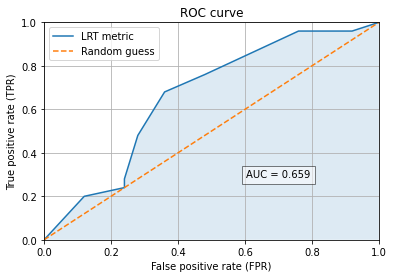

<Figure size 432x288 with 0 Axes>

In [23]:
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

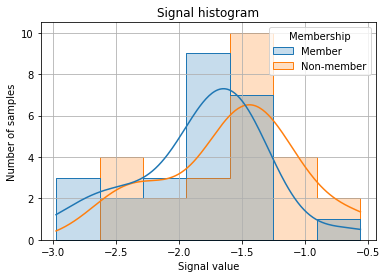

<Figure size 432x288 with 0 Axes>

In [24]:
SignalHistogramReport.generate_report(
    metric_result=result,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)